# ConvLSTM

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from ConvLSTM import *

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

figures saved to ../Figures/Modeling/ConvLSTM
figures saved to ../Datasets/fastStorage/images


## Data exploration

In [2]:
# Load data
VM_NUM = 917
VM = load_VM(f'{VM_NUM}.csv')
# VM = load_VM('599.csv')
# Make it univariate
df = VM[['CPU usage [MHZ]']]

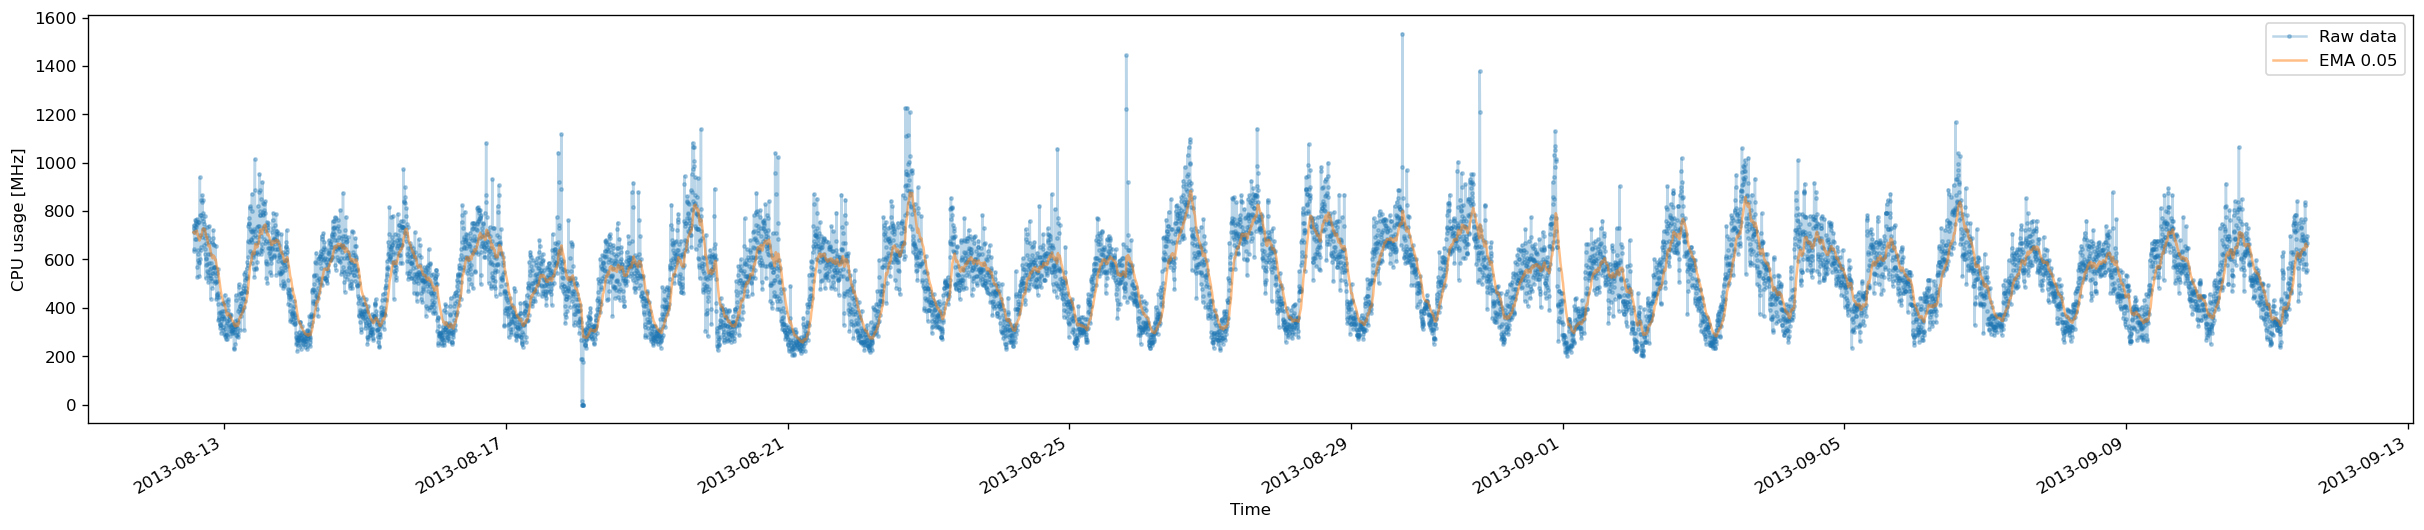

In [3]:
%matplotlib inline
plot_timeSeries(df['CPU usage [MHZ]'], ylabel='CPU usage [MHz]')

## Split the data

In [4]:
# (70%, 20%, 10%) split for the training, validation, and test sets
train_df, val_df, test_df = split_data(df)

## Normalizing the data

In [5]:
scaler = MinMaxScaler()
train_df, val_df, test_df = data_transformation(scaler, train_df, val_df, test_df)

## Cross-modeling

In [5]:
train_df, val_df, _ = split_data(df,0.8,0.19)
scaler = MinMaxScaler()
train_df, val_df, _ = data_transformation(scaler, train_df, val_df, _)

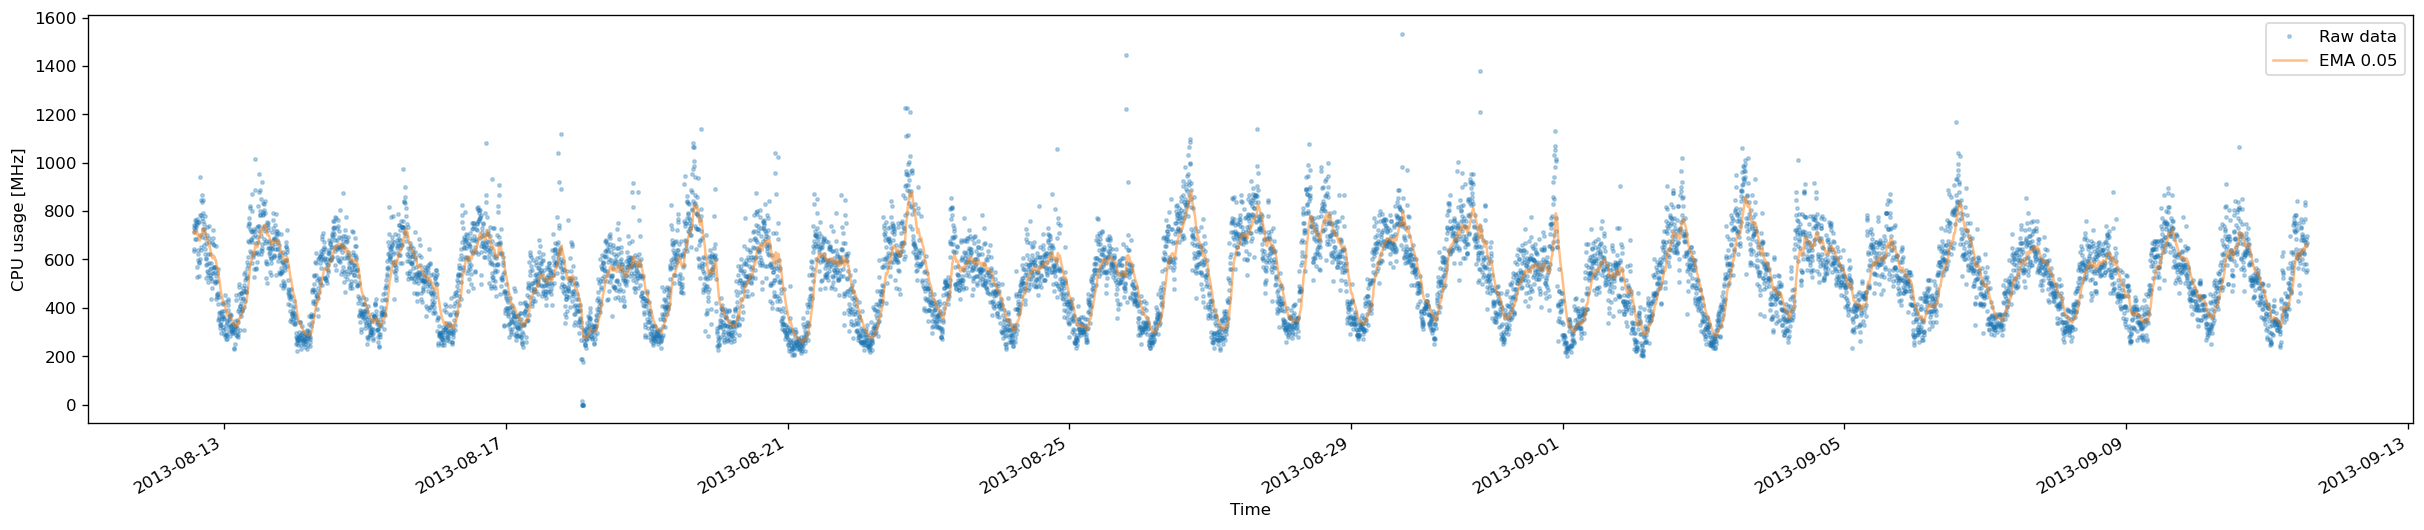

In [7]:
# Load data
VM_NUM_test = 340
VM_test = load_VM(f'{VM_NUM_test}.csv')
# VM = load_VM('599.csv')
# Make it univariate
df_test = VM[['CPU usage [MHZ]']]
%matplotlib inline
plot_timeSeries(df_test['CPU usage [MHZ]'], ylabel='CPU usage [MHz]')

In [11]:
scaler = MinMaxScaler()
df_test.loc[:, df_test.columns] = scaler.fit_transform(df_test.loc[:, df_test.columns])
test_df = df_test.copy()

/var/folders/mb/34bz2n2j38ldt4zjxtdpnfg80000gp/T/ipykernel_52089/754266856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, df_test.columns] = scaler.fit_transform(df_test.loc[:, df_test.columns])


## ConvLSTM

In [35]:
ConvLSTM_model = ConvLSTMModel(input_width=64,
                            label_width=32,
                            df=df,
                            image_width=64,
                            model_name='LRCN',
                            name='917/labels_32',
                            train_df=train_df,
                            val_df=val_df,
                            test_df=test_df,
                            epoch=50,
                            batch_size=16,
                            n_frames=1,
                            model_path='./logs/ConvLSTM/LRCN/917/label_32/checkpoints/ConvLSTM_model_2022_03_30__12_20_56.hdf5',
                            # numeric=True,
                            # overlapping=0.9
                            )

In [7]:
input, labels = ConvLSTM_model.train

### Data Visualization

In [12]:
%matplotlib inline
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(input)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    # ax.imshow(np.squeeze(input[data_choice][idx]), cmap="gray")
    ax.imshow(np.squeeze(input[data_choice+idx]), cmap="gray")
    ax.set_title(f"Sample {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
# plt.show()
save_path = os.path.join('../Figures/Modeling/Thesis', 'mpl_image_ratio3.png')
plt.savefig(save_path, bbox_inches='tight')
plt.close(fig)

Displaying frames for example 71.


In [ ]:
%matplotlib inline
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 8, figsize=(10, 6))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(input)), size=1)[0]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(input[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(labels[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

### Training

In [ ]:
history = ConvLSTM_model.compile_and_fit()

In [36]:
# Load model
# Load model
if ConvLSTM_model.model_path is not None:
    ConvLSTM_model.model = tf.keras.models.load_model(ConvLSTM_model.model_path)
else:
    ConvLSTM_model.model = get_model(ConvLSTM_model, ConvLSTM_model.model_name)

In [38]:
# Predict
ConvLSTM_model.numeric = True
if ConvLSTM_model.numeric is False:
    pred, img_pred, pred_df_trf = ConvLSTM_model.prediction(scaler)
else:
    pred, pred_df_trf = ConvLSTM_model.prediction(scaler)

Inference:
Inference time: 0.58 sec
2/2 [==============================] - 0s 32ms/step - loss: 0.0105 - mean_absolute_error: 0.0829


2022-05-20 10:43:35.291170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 10:43:35.368291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


                               0
MAE                 6.923646e+01
MAPE                1.657318e+08
RMSE                9.787555e+01
MASE                1.171159e+00
train_time [s]      0.000000e+00
inference_time [s]  1.641835e+01
model_size [B]      0.000000e+00
IoU                 1.956707e-01
DTW                 3.343504e+05
Unable to write to file
               MAE         MAPE
count  8608.000000  8608.000000
mean     69.236456          inf
std      69.184487          NaN
min       0.000000     0.000000
25%      18.806697     3.804357
50%      49.573255    10.077413
75%      99.146702    19.325815
max     906.966654          inf
Unable to write to file


/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/DataExploration/BitbrainsUtils.py:277: RuntimeWarning: divide by zero encountered in true_divide
  return np.abs((y - y_hat)/y)*100


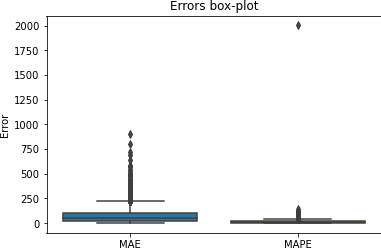

In [15]:
metrics = ConvLSTM_model.evaluation(pred_df_trf, scaler)

figures saved to ../Figures/Modeling/ConvLSTM
figures saved to ../Datasets/fastStorage/images
              MAE        MAPE
count  848.000000  848.000000
mean    76.626793   14.806211
std     62.606804   11.344046
min      0.086667    0.017123
25%     27.039989    5.737260
50%     61.099939   12.459526
75%    113.901610   21.139131
max    389.306515   75.933735
Unable to write to file


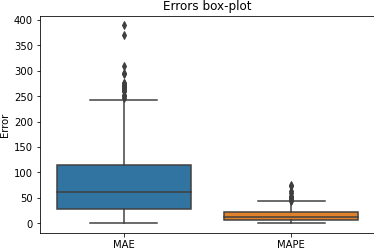

In [14]:
errors = ConvLSTM_model.errors_boxplot(pred_df_trf, scaler)

In [23]:
errors.describe()

figures saved to ../Figures/Modeling/ConvLSTM
figures saved to ../Datasets/fastStorage/images


,MAE,MAPE,RMSE
count,848.000000,848.000000,848.000000
mean,86.967614,17.204596,86.967614
std,67.210085,12.837112,67.210085
min,0.086667,0.017123,0.086667
25%,35.381653,7.343138,35.381653
50%,72.366617,14.317482,72.366617
75%,120.899953,24.969458,120.899953
max,407.246508,69.966887,407.246508


In [14]:
%matplotlib tk
# Test_pred dataset
input = ConvLSTM_model.test_pred[0]
label = ConvLSTM_model.test_pred[1]
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
# Plot the original frames.
axes[0][2].set_title('Input')
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(input[idx]), cmap="gray")
    # ax.set_title(f"Sample {idx}")
    ax.axis("off")
# Plot the new frames.
axes[1][2].set_title('Labels')
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(label[idx]), cmap="gray")
    # ax.set_title(f"Sample {idx}")
    ax.axis("off")
axes[2][2].set_title('Output')
# Prediction
for idx, ax in enumerate(axes[2]):
    ax.imshow(np.squeeze(pred[idx]), cmap="gray")
    # ax.set_title(f"Sample {idx}")
    ax.axis("off")
# Prediction binarize
axes[3][2].set_title('Output binarized')
for idx, ax in enumerate(axes[3]):
    ax.imshow(np.squeeze(ConvLSTM_model.binarize_image(pred[idx])), cmap="gray")
    # ax.set_title(f"Sample {idx}")
    ax.axis("off")

In [29]:
# Figure for forecasting part of image
img_input = ConvLSTM_model.extract_forecast_from_image(ConvLSTM_model.test_pred[0])
img_label = ConvLSTM_model.extract_forecast_from_image(ConvLSTM_model.test_pred[1])
# Binarize the image
# img_pred_bin = ConvLSTM_model.binarize_image(img_pred)
fig, axes = plt.subplots(3, 1, figsize=(15, 6))
plt.suptitle('Test set: GT vs prediction', fontsize=16)
# Ground Truth
axes[0].imshow(img_input, cmap="gray")
axes[0].set_title('Input')
axes[0].axis("off")
# Prediction
axes[1].imshow(img_label, cmap="gray")
axes[1].set_title('Label')
axes[1].axis("off")
# Prediction
axes[2].imshow(img_pred, cmap="gray")
axes[2].set_title('Prediction')
axes[2].axis("off")


(-0.5, 831.5, 99.5, -0.5)

In [13]:
%matplotlib tk
# Figure of raw output
# Ground truth
gt = ConvLSTM_model.test_pred[1]
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))
# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(gt[idx]), cmap="gray")
    ax.set_title(f"Sample {idx}")
    ax.axis("off")
# Plot the new frames.
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(ConvLSTM_model.binarize_image(pred[idx])), cmap="gray")
    ax.set_title(f"Sample {idx}")
    ax.axis("off")
plt.show()

In [13]:
aux = pred[0,...]
aux = np.squeeze(aux)

In [26]:
%matplotlib tk
# Figure forecast
# Define default kwargs
defaultKwargs = {'marker': 'o',
                 'linestyle': '-',
                 'alpha': 0.3,
                 'markersize': 2}
kwargs_forecast = {'marker': 'o',
                   'linestyle': '-',
                   'alpha': 0.5,
                   'markersize': 2,
                   'color': 'tab:orange'}
fig = plt.figure(dpi=200)
plt.grid()
ConvLSTM_model.df['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred_df_trf['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Actual vs Forecast')
plt.grid()
plt.legend()
plt.show()

In [15]:
# Test set
test_trf = scaler.inverse_transform(ConvLSTM_model.test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=ConvLSTM_model.test_df.columns, index=ConvLSTM_model.test_df.index)
# Figure zoom
fig = plt.figure(dpi=200)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred_df_trf['CPU usage [MHZ]'].shift(periods=-16).plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Actual vs Forecast (Zoom)')
plt.grid()
plt.legend()

In [28]:
 # Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, sharey=True)
plt.suptitle('Test set: GT vs prediction', fontsize=16)
# Ground Truth
axes[0].plot(test_df_trf['CPU usage [MHZ]'],label='actual', color='k', **defaultKwargs)
axes[0].set_title('Ground truth')
axes[0].set_ylabel('CPU usage [MHz]')
# Prediction
axes[1].plot(pred_df_trf['CPU usage [MHZ]'], label='forecast', **kwargs_forecast)
axes[1].set_title('Prediction')
axes[1].set_ylabel('CPU usage [MHz]')
axes[1].set_xlabel('Time')

Text(0.5, 0, 'Time')

In [29]:
 # Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, sharey=True)
plt.suptitle('Test set: GT vs prediction', fontsize=16)
# Ground Truth
axes[0].plot(df['CPU usage [MHZ]'],label='actual', color='k', **defaultKwargs)
axes[0].set_title('Ground truth')
axes[0].set_ylabel('CPU usage [MHz]')
# Prediction
axes[1].plot(pred_df_trf['CPU usage [MHZ]'], label='forecast', **kwargs_forecast)
axes[1].set_title('Prediction')
axes[1].set_ylabel('CPU usage [MHz]')
axes[1].set_xlabel('Time')

Text(0.5, 0, 'Time')

# Playground

In [22]:
ConvLSTM_model.create_image_dataset(train_df, os.path.join(DATASET_PATH,'917','train') )

In [ ]:
img = cv2.imread('../Datasets/fastStorage/images/917/train/train_1.png', cv2.IMREAD_GRAYSCALE)

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128
# Resize the Frame to fixed height and width.
resized_img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
# Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
normalized_img = resized_img / 255

In [ ]:
cv2.imshow('Image',normalized_img)
cv2.waitKey(0)

In [9]:
%matplotlib tk
# Get numpy image from matplotlib from buffer (without saving)
fig = full_frame(figsize, dpi)
# set y-axis limits
plt.plot(train_df.iloc[:80,:], ',', color='black')
plt.ylim(0,1)
buf = io.BytesIO()
plt.savefig(buf, format="png", dpi=dpi)
buf.seek(0)
img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
buf.close()
img = cv2.imdecode(img_arr, cv2.IMREAD_GRAYSCALE)

In [10]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [12]:
y_train = ConvLSTM_model.train[1]
y_train = y_train[0,0,...]
y_train = np.squeeze(y_train)

## Image with numpy

In [6]:
# Create image using numpy
data = np.array(train_df.iloc[:80,:]).squeeze()

In [7]:
# Get the height of each column (0-100)
level = np.round(data*100)
# Invert y-axis from bottom to top
level = 100 - level

In [8]:
WIDTH = 64
HEIGHT = 100
img = np.zeros((HEIGHT, WIDTH))
# Fill with ones the corresponding level
for i in range(img.shape[1]):
    img[int(level[i]),i] = 255

In [9]:
cv2.imshow('Image', img)
cv2.waitKey(0)

27

In [10]:
save_path = os.path.join(FIGURES_PATH, 'ConvLSTM', 'Sample.png')
cv2.imwrite(save_path, img)

True

## Image matplotlib

In [7]:
# Create image using numpy
data = np.array(train_df.iloc[:64,:]).squeeze()

In [17]:
img = ConvLSTM_model.create_image_matplotlib(data, 64)

figures saved to ../Figures/Modeling/ConvLSTM
figures saved to ../Datasets/fastStorage/images


In [18]:
cv2.imshow('Image', img)
cv2.waitKey(0)

27

## Recurrence plot

In [10]:
from pyts.image import RecurrencePlot, GramianAngularField

In [17]:
# Create image using numpy
data = np.array(train_df.iloc[:288,:].squeeze())
x = np.array([data])
rp = RecurrencePlot()
X_rp = rp.transform(x)

In [18]:
%matplotlib tk
plt.imshow(X_rp[0], cmap='binary', origin='lower')

## Gramian angular field

In [62]:
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(x)

In [65]:
plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')

In [ ]:
cv2.destroyAllWindows()
cv2.waitKey(-1)

## Create synthetic dataset

In [ ]:
def synthetic_dataset_black(df, freq):
    time = np.arange(0, len(df))
    amplitude = np.sin(2*np.pi*freq*time)
    amplitude[0] = -4
    amplitude[len(df)-1] = 4
    df['CPU usage [MHZ]'] = amplitude
    return df

In [7]:
%matplotlib tk
freq= 1/288
time = np.arange(0, len(df))
amplitude = np.sin(2*np.pi*freq*time)
plt.plot(amplitude)

In [11]:
new_df = df.copy()

In [12]:
new_df = synthetic_dataset_black(new_df, 1/25)

<AxesSubplot:xlabel='Timestamp [ms]'>

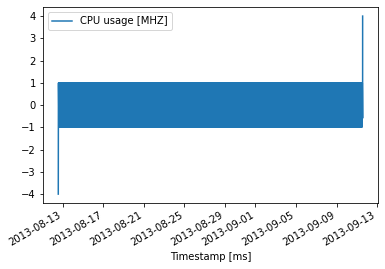

In [13]:
new_df.plot()

In [23]:
df.plot()

<AxesSubplot:xlabel='Timestamp [ms]'>

## IoU

In [38]:
%matplotlib tk
plt.imshow(img_pred, cmap="gray")

In [9]:
# Preprocess IoU
def preprocessIoU(img, epsilon):
    levels = np.argmax(img, axis=0)
    # Column dilation of the pixels
    for column, level in enumerate(levels):
        for i in range(1, epsilon+1):
            # Add white pixel on top
            img[level+i, column] = 255
            # Add white pixel on bottom
            img[level-i, column] = 255
    return img

In [27]:
%matplotlib tk
img = np.copy(img_pred)
img_proc = preprocessIoU(img, 1)
plt.imshow(img_proc, cmap="gray")

In [18]:
# Image ground truth
img_gt = ConvLSTM_model.create_image_numpy(test_df.iloc[:len(pred_df_trf),0], len(pred_df_trf))
img_gt = preprocessIoU(img_gt, 1)

In [25]:
column_gt = img_gt[:,0]
column_pred = img_proc[:,0]
# Get the rows whose value is white
rows_gt = [i for i,_ in enumerate(column_gt) if _ == 255]
rows_pred = [i for i,_ in enumerate(column_pred) if _ == 255]
yA = max(min(rows_gt), min(rows_pred))
yB = min(max(rows_gt), max(rows_pred))
interArea = abs(max((yB - yA), 0))

In [35]:
def columnIoU(img_pred, img_gt, epsilon):
    # Preprocess IoU with epsilon
    img_gt = preprocessIoU(np.copy(img_gt), epsilon)
    img_pred = preprocessIoU(np.copy(img_pred), epsilon)
    IoU = []
    for i in range(img_pred.shape[1]):
        # Get coordinates of bounding box
        column_gt = img_gt[:,i]
        column_pred = img_proc[:,i]
        # Get the rows whose value is white
        rows_gt = [i for i,_ in enumerate(column_gt) if _ == 255]
        rows_pred = [i for i,_ in enumerate(column_pred) if _ == 255]
        # determine the y-coordinates of the intersection rectangle (width is always 1)
        yA = max(min(rows_gt), min(rows_pred))
        yB = min(max(rows_gt), max(rows_pred))

        # compute the area of intersection rectangle
        interArea = abs(max((yB - yA), 0))
        if interArea == 0:
            IoU.append(0)
            continue
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxGt = abs(max(rows_gt) - min(rows_gt))
        boxPred = abs(max(rows_pred) - min(rows_pred))

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxGt + boxPred - interArea)
        IoU.append(iou)
    # return the intersection over union value
    return np.mean(IoU)

In [40]:
IoU = columnIoU(img_pred, img_gt, 0)
np.mean(IoU)

0.10770440251572326